## Develop a pipeline to compute quality control statistics necessary for submission to GISAID

Below we compute a series of quality control statistics for GISAID using:
- the coverage files
- the consensus fasta

For the "sequencing depth (average)" statistic, it would be best to use the .fastq files, however at present I do not have access.

In [1]:
import os
import sys

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.dpi"] = 100

## Functions

### Loading coverage files

In [2]:
def load_coverage_files(sample_dir, verbose=False):
    """
    Load coverage files from ARCTIC output
    
    Parameters
        sample_dir : str
            Path to the sample directory. Within this
            directory there should be coverage files
            generated from the ARCTIC pipeline which
            have a '.depths' suffix.
        verbose : bool
            TODO
            
    Returns
        df : DataFrame, shape (2, n_sites)
            A data frame of two columns containing
            genomic position 'pos' and coverage 'cov'
            data. Each position is representd only once;
            the coverage across multiple primer pools is summed.
    
    """
    
    # Identify coverage files
    cov_files = [fn for fn in os.listdir(sample_dir) if fn.endswith(".depths")]
    
    # Prepare storage
    dt = {
        "pos": [],
        "cov": []
    }

    # Iterate over pools
    for cov_fn in cov_files:

        # Open file
        fn = os.path.join(data_path, cov_fn)
        with open(fn, "r") as f:

            # Iterate over lines
            for line in f:

                # Parse line
                _, _, pos, cov = line.strip().split("\t")

                # Store results
                dt["pos"].append(int(pos))  # note data type coercion
                dt["cov"].append(int(cov))  # ""
    
    # Convert to data frame
    df = pd.DataFrame(dt)
    
    # Get total coverage at each position
    df = (df
          .groupby("pos")
          .sum()
          .reset_index()
         )
    
    return df

### Computing statistics

In [3]:
def get_contig_lengths(cov):
    """
    Given a coverage profile, return an array
    giving the list of all the contigs
    
    In this context a contig is defined as a contiguous
    region of sequence with a coverage > 0X.
    
    Parameters
        cov : array, int, shape (n_sites)
            Coverage along the genome.
            
    Returns
        ll : ndarray, int, shape(n_contigs)
            An array containing the length of all
            the contigs
            
    """
    
    contigs = []
    l = 0
    for covered in cov > 0:
        if covered:
            l += 1
        elif l > 0:
            contigs.append(l)
            l = 0
    if l > 0: contigs.append(l)  # append last segment

    return np.array(contigs)

In [4]:
def calc_contig_n50(cov):
    """
    Compute the N50 contig length
    
    Parameters
        cov : array, int, shape (n_sites)
            Coverage along the genome.
            
    Returns
        _ : int
            The N50 contig length; 50% of the total
            contig length is contained in contigs
            of this length or smaller.

    """
    
    contigs = get_contig_lengths(cov)
    
    if len(contigs) > 0:
        contigs.sort()
        total_contig = contigs.sum()
        cum_contig_frac = (contigs / total_contig).cumsum()
        ix = np.argmax(cum_contig_frac > 0.5)
        
    else:
        return np.nan
    
    return contigs[ix]
    

In [5]:
def calc_gisaid_stats(df, depth_threshold=10):
    """
    Calculate bioinformatics statistics required for 
    GISAD submission
    
    Parameters
        df : DataFrame, shape (2, n_sites)
            Pandas DataFrame containing two columns,
            one for genomic position "pos" and one for
            coverage "cov". Rows are consecutive
            sites in the genome.
        depth_threshold : int, optional
            Used to calculate breadth.
            
    Returns
        dt : dict
            Dictionary containing all GISAID QC
            statistics, excluding 'Ns per 100 kbp'
            
    """
    
    # Reference genome length
    genome_length = df["pos"].max() - df["pos"].min()
    
    # Consensus genome length
    covered = df["cov"] > 0
    consensus_genome_length = df[covered]["pos"].max() - df[covered]["pos"].min() + 1
    
    # Total base pairs sequenced
    # NB: this is post-mapping and depth truncation
    number_base_pairs = df["cov"].sum()
    
    # Sequence depth (average)
    sequencing_depth_avg = number_base_pairs / genome_length
    
    # Coverage depth (average)
    coverage_depth = number_base_pairs / consensus_genome_length
    
    # Assembly coverage breadth (as percentage)
    coverage_breadth = 100 * (df["cov"] >= depth_threshold).sum() / genome_length
    
    # Mean contig length
    contigs = get_contig_lengths(df["cov"])
    mean_contig_length = contigs.mean()
    
    # N50 contig length
    n50_contig_length = calc_contig_n50(df["cov"])
    
    
    # Package key statistics into a dictionary
    dt = {
        "sequencing_depth_avg": sequencing_depth_avg,
        "coverage_breadth": coverage_breadth,
        "assembly_coverage_depth": coverage_depth,
        "number_base_pairs": number_base_pairs,
        "consensus_genome_length": consensus_genome_length,
        "mean_contig_length": mean_contig_length,
        "N50": n50_contig_length
    }
    
    return dt

### Computing 'Ns per 100kbp'
- Requires loading the consensus sequence

In [6]:
def calc_ns_per_100kbp(consensus_fasta, verbose=True):
    """
    Calculate the number of Ns per 100kbp from
    a consensus FASTA
    
    Parameters
        consensus_fasta : str
            Path to the consensus fasta file.
        verbose : bool
            Switch for print diagnostics.
    
    Returns
        ns_per_100kbp : float
            The average number of Ns per 100kbp.
    
    """
    
    # Open consensus fasta
    with open(consensus_fasta, "r") as f:
    
        # Parse header
        header = f.readline().strip()

        # Parse sequence
        seq = ""
        for line in f:
            seq += line.strip()

        # Calculate statistics
        seq_length = len(seq)

    # Number of Ns
    num_ns = sum([1 for c in seq if c == "N"])

    # Ns per 100 kbp
    ns_per_100kbp = num_ns / seq_length * 100 * 10 **3

    if verbose:
        print("FASTA name: %s" % consensus_fasta)
        print("Header: %s" % header)
        print("Sequence length (bp): %d" % seq_length)
        print("Number of Ns: %d" % num_ns)
        print("Ns per 100kbp: %.02f" % ns_per_100kbp)
        
    return ns_per_100kbp

## Example workflow

In [7]:
data_dir = "../../data"
processed_dir = "processed"
sample_dir = "C01"
run_dir = "29"

In [8]:
data_path = os.path.join(data_dir,
                         sample_dir,
                         processed_dir,
                         run_dir)

In [9]:
os.listdir(data_path)

['29.muscle.out.fasta',
 '29.trimmed.rg.sorted.bam.bai',
 '29.pass.vcf.gz',
 '29.primertrimmed.rg.sorted.bam',
 '29.primertrimmed.rg.sorted.bam.bai',
 '29.fail.vcf',
 '29.alignreport.txt',
 '29.preconsensus.fasta',
 '29.coverage_mask.txt.nCoV-2019_1.depths',
 '29.sorted.bam.bai',
 '29.trimmed.rg.sorted.bam',
 '29.consensus.fasta',
 '29.coverage_mask.txt',
 '29-boxplot.png',
 '29.primers.vcf',
 '29.nCoV-2019_2.vcf',
 '29.coverage_mask.txt.nCoV-2019_2.depths',
 '29.nCoV-2019_1.vcf',
 '29.sorted.bam',
 '29.pass.vcf.gz.tbi',
 '29.muscle.in.fasta',
 '29.alignreport.er',
 '29.merged.vcf',
 '29.minion.log.txt',
 '29-barplot.png']

In [10]:
df = load_coverage_files(data_path)

In [11]:
df.head()

,pos,cov
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


Text(0, 0.5, 'Coverage')

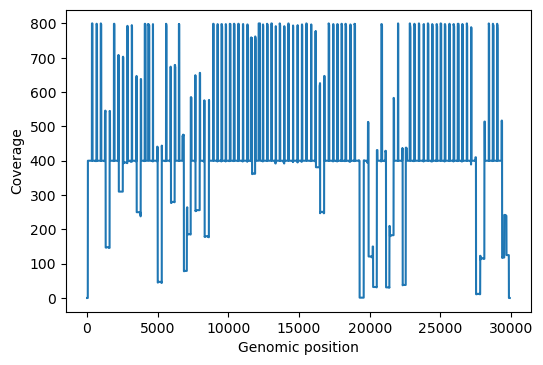

In [12]:
fig, ax = plt.subplots(1, 1)

ax.plot(df["pos"], df["cov"])
ax.set_xlabel("Genomic position")
ax.set_ylabel("Coverage")

Looks correct. Notice thresholding at 400X coverage.

In [13]:
stats_dt = calc_gisaid_stats(df)

In [14]:
ns_per_100kbp = calc_ns_per_100kbp(os.path.join(data_path, "29.consensus.fasta"))

FASTA name: ../../data/C01/processed/29/29.consensus.fasta
Header: >29/ARTIC/nanopolish MN908947.3
Sequence length (bp): 29903
Number of Ns: 717
Ns per 100kbp: 2397.75


In [15]:
stats_dt.update({"ns_per_100kbp": ns_per_100kbp})

In [16]:
stats_dt

{'sequencing_depth_avg': 388.01718948565315,
 'coverage_breadth': 98.61213296769446,
 'assembly_coverage_depth': 389.58061916593914,
 'number_base_pairs': 11602490,
 'consensus_genome_length': 29782,
 'mean_contig_length': 29782.0,
 'N50': 29782,
 'ns_per_100kbp': 2397.7527338394143}

Looks reasonable.